# Synthetic image generation with Generative Models

## Path setting

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os
module_path = "../.."
sys.path.append(os.path.abspath(module_path))

## 1. Create Bedrock client

In [3]:
from pprint import pprint
from termcolor import colored
from utils import bedrock
from utils.bedrock import bedrock_info

### ---- ⚠️ Un-comment and edit the below lines as needed for your AWS setup ⚠️ ----
- os.environ["AWS_DEFAULT_REGION"] = "<REGION_NAME>"  # E.g. "us-east-1"
- os.environ["AWS_PROFILE"] = "<YOUR_PROFILE>"
- os.environ["BEDROCK_ASSUME_ROLE"] = "<YOUR_ROLE_ARN>"  # E.g. "arn:aws:..."
- os.environ["BEDROCK_ENDPOINT_URL"] = "<YOUR_ENDPOINT_URL>"  # E.g. "https://..."

In [4]:
boto3_bedrock = bedrock.get_bedrock_client(
    assumed_role=os.environ.get("BEDROCK_ASSUME_ROLE", None),
    endpoint_url=os.environ.get("BEDROCK_ENDPOINT_URL", None),
    region=os.environ.get("AWS_DEFAULT_REGION", None),
)

print (colored("\n== FM lists ==", "green"))
pprint (bedrock_info.get_list_fm_models(verbose=False))

Create new client
  Using region: None
  Using profile: None
boto3 Bedrock client successfully created!
bedrock-runtime(https://bedrock-runtime.us-east-1.amazonaws.com)

== FM lists ==
{'Claude-Instant-V1': 'anthropic.claude-instant-v1',
 'Claude-V1': 'anthropic.claude-v1',
 'Claude-V2': 'anthropic.claude-v2',
 'Claude-V2-1': 'anthropic.claude-v2:1',
 'Claude-V3-5-Sonnet': 'anthropic.claude-3-5-sonnet-20240620-v1:0',
 'Claude-V3-5-V-2-Sonnet': 'anthropic.claude-3-5-sonnet-20241022-v2:0',
 'Claude-V3-5-V-2-Sonnet-CRI': 'us.anthropic.claude-3-5-sonnet-20241022-v2:0',
 'Claude-V3-Haiku': 'anthropic.claude-3-haiku-20240307-v1:0',
 'Claude-V3-Opus': 'anthropic.claude-3-sonnet-20240229-v1:0',
 'Claude-V3-Sonnet': 'anthropic.claude-3-sonnet-20240229-v1:0',
 'Cohere-Embeddings-En': 'cohere.embed-english-v3',
 'Cohere-Embeddings-Multilingual': 'cohere.embed-multilingual-v3',
 'Command': 'cohere.command-text-v14',
 'Command-Light': 'cohere.command-light-text-v14',
 'Jurassic-2-Mid': 'ai21.j2-mid

## 2. LLM 정의

In [5]:
from utils.bedrock import bedrock_model
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler

In [6]:
llm = bedrock_model(
    model_id=bedrock_info.get_model_id(model_name="Claude-V3-5-V-2-Sonnet-CRI"),
    #model_id=bedrock_info.get_model_id(model_name="Claude-V3-5-Sonnet"),
    #model_id=bedrock_info.get_model_id(model_name="Nova-Pro-CRI"),
    bedrock_client=boto3_bedrock,
    stream=True,
    callbacks=[StreamingStdOutCallbackHandler()],
    inference_config={
        'maxTokens': 1024,
        'stopSequences': ["\n\nHuman"],
        'temperature': 0.01,
        #'topP': ...,
    }
    #additional_model_request_fields={"top_k": 200}
)

In [7]:
image_generation_model = bedrock_model(
    model_id=bedrock_info.get_model_id(model_name="Nova-Canvas"),
    bedrock_client=boto3_bedrock
)

## 3. Masking images
### 3.1 Get masking imges from online app.
- Go to [Inpaint-mask-maker](https://huggingface.co/spaces/stevhliu/inpaint-mask-maker)
    - Upload image
    - Select masking area by your mouse
    - Download masking image (webp format) and `upload` it to `masking` folder
![nn](./imgs/img-variation/masking_samples.png)

### 3.2 Preprcessing for masking images
- 3.1 이미지 업로드 위치
    - 원본 이미지: **`'/datasets/0-origin/<"event_name">/<index-event-name.jpg>>'`**
    - 마스킹 이미지 (webp): **`'./datasets/1-masking/<"event-name">/masking/<index-"event-name-mask".webp>'`**

In [8]:
import os
from PIL import Image, ImageOps

In [9]:
def webp_to_png_with_inverse(input_path, output_path=None):
    """
    WebP 이미지를 PNG로 변환하고 inverse masking된 이미지도 함께 생성하는 함수
    
    Args:
        input_path (str): WebP 파일 경로
        output_path (str, optional): 저장할 PNG 파일 경로. 
                                   None인 경우 원본 파일명에 .png 확장자 사용
    Returns:
        tuple: (일반 변환 이미지 경로, inverse 이미지 경로)
    """
    try:
        # 이미지 열기
        img = Image.open(input_path)
        
        # output_path가 지정되지 않은 경우 원본 파일명 사용
        if output_path is None:
            file_name = os.path.splitext(input_path)[0]
            output_file_path = file_name + '.png'
            inverse_output_path = file_name + '-inverse.png'
        else:
            # output_path가 지정된 경우, inverse 이미지 경로 생성
            output_file_path = f'{os.path.splitext(input_path)[0]}.png'
            inverse_output_path = f'{os.path.splitext(output_path)[0]}/{os.path.splitext(input_path)[0].split("/")[-1]}-inverse.png'

        # 원본 이미지 PNG로 저장
        img.save(output_file_path, 'PNG')
        print(f'일반 변환 완료: {output_file_path}')
        
        # Inverse masking 적용
        if img.mode == 'RGBA':
            # RGBA 이미지의 경우 알파 채널 보존
            r, g, b, a = img.split()
            rgb_img = Image.merge('RGB', (r, g, b))
            inverse_img = ImageOps.invert(rgb_img)
            inverse_img.putalpha(a)
        else:
            # RGB 또는 다른 모드의 이미지
            inverse_img = ImageOps.invert(img)

        print (inverse_output_path)
        
        # Inverse 이미지 저장
        inverse_img.save(inverse_output_path, 'PNG')
        print(f'Inverse 변환 완료: {inverse_output_path}')
        
        return output_path, inverse_output_path
        
    except Exception as e:
        print(f'변환 중 오류 발생: {str(e)}')
        return None, None

def convert_folder_with_inverse(folder_path, output_path=None):
    """
    폴더 내의 모든 WebP 파일을 PNG로 변환하고 inverse 이미지도 생성
    
    Args:
        folder_path (str): JPG, PNG 파일들이 있는 폴더 경로
    """
    converted_files = []
    for filename in os.listdir(folder_path):
        if filename.lower().rsplit(".", 1)[1] in ["webp"]:
            input_path = os.path.join(folder_path, filename)
            normal_path, inverse_path = webp_to_png_with_inverse(input_path, output_path)
            if normal_path and inverse_path:
                converted_files.append((normal_path, inverse_path))
    
    return converted_files

In [10]:
# 특정 폴더의 모든 파일 변환
converted_files = convert_folder_with_inverse(
    folder_path='./datasets/1-masking/event-fall/masking/',
    output_path='./datasets/1-masking/event-fall/inversed-masking/'
)

일반 변환 완료: ./datasets/1-masking/event-fall/masking/1-event-fall-mask-2.png
./datasets/1-masking/event-fall/inversed-masking//1-event-fall-mask-2-inverse.png
Inverse 변환 완료: ./datasets/1-masking/event-fall/inversed-masking//1-event-fall-mask-2-inverse.png
일반 변환 완료: ./datasets/1-masking/event-fall/masking/1-event-fall-mask.png
./datasets/1-masking/event-fall/inversed-masking//1-event-fall-mask-inverse.png
Inverse 변환 완료: ./datasets/1-masking/event-fall/inversed-masking//1-event-fall-mask-inverse.png


## 4. Synthetic image generation

In [21]:
import io
import json
import base64
import random
import matplotlib.pyplot as plt
from utils.common_utils import retry_with_exponential_backoff, retry

In [68]:
def _png_to_bytes(file_path):
    try:
        with open(file_path, "rb") as image_file:
            # 파일을 바이너리 모드로 읽기
            binary_data = image_file.read()

            # 바이너리 데이터를 base64로 인코딩
            base64_encoded = base64.b64encode(binary_data)

            # bytes 타입을 문자열로 디코딩
            base64_string = base64_encoded.decode('utf-8')

            return binary_data, base64_string

    except FileNotFoundError:
        return "Error: 파일을 찾을 수 없습니다."
    except Exception as e:
        return f"Error: {str(e)}"

@retry(total_try_cnt=5, sleep_in_sec=10)
def _img_generation_show_and_store(image_generation_model, body, original_image_path, mask_image_path=None, output_path=None, seperator=""):
    # 원본 이미지 로드
    original_image = Image.open(original_image_path)
    
    # 생성된 이미지 얻기
    response = image_generation_model.bedrock_client.invoke_model(
        body=body,
        modelId=image_generation_model.model_id
    )
    response_body = json.loads(response.get("body").read())

    images = response_body.get("images")
    for idx, base64_image in enumerate(images):
 
        image_data = base64.b64decode(base64_image)
        generated_image = Image.open(io.BytesIO(image_data))
        
        # mask_image_path의 유무에 따라 subplot 개수 조정
        if mask_image_path:
            # 마스크 이미지가 있는 경우 3개의 subplot 생성
            fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 7))
            
            # 원본 이미지 표시
            ax1.imshow(original_image)
            ax1.axis('off')
            ax1.set_title('Original Image')
            
            # 마스크 이미지 표시
            mask_image = Image.open(mask_image_path)
            ax2.imshow(mask_image)
            ax2.axis('off')
            ax2.set_title('Mask Image')
            
            # 생성된 이미지 표시
            ax3.imshow(generated_image)
            ax3.axis('off')
            ax3.set_title('Generated Image')
        else:
            # 마스크 이미지가 없는 경우 2개의 subplot 생성
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
            
            # 원본 이미지 표시
            ax1.imshow(original_image)
            ax1.axis('off')
            ax1.set_title('Original Image')
            
            # 생성된 이미지 표시
            ax2.imshow(generated_image)
            ax2.axis('off')
            ax2.set_title('Generated Image')
        
        plt.tight_layout()  # 레이아웃 조정
        plt.show()

        if output_path is not None:
            filename, extenstion = os.path.basename(original_image_path).split(".")
            variation_filename = f'{filename}-variation-{seperator}-{idx}.png'
            output_file_path = os.path.join(output_path, variation_filename)
            generated_image.save(output_file_path)
    
            output_dir = "generated_images"  # 저장할 디렉토리
            os.makedirs(output_dir, exist_ok=True)  # 디렉토리가 없으면 생성

    return "completed"
            

### 4.2 Image `inpatinitng`
  - mask: 바꾸고 싶은 부분이 검은색 

#### Case 1: Replace a subject
![nn](./imgs/img-variation/mask-1.png)

In [72]:
event_type = "event-fall"
seperator = "inpatinitng-type-1"

origin_img_path = f'./datasets/0-origin/{event_type}/1-event-fall.jpg'
origin_img_bytes, origin_img_base64 = _png_to_bytes(origin_img_path)

mask_img_path = f'./datasets/1-masking/{event_type}/inversed-masking/1-event-fall-mask-inverse.png'
mask_img_bytes, mask_img_base64 = _png_to_bytes(mask_img_path)
output_path = f'./datasets/2-variation/{event_type}'

In [73]:
body = json.dumps(
    {
        "taskType": "INPAINTING",
        "inPaintingParams": {
            "text": "A person lying unconscious on the floor, top-down view from CCTV angle, surveillance camera perspective, high-angle shot, full body view, realistic",
            "negativeText": "bad quality, low resolution, cartoon, blurry",
            "image": origin_img_base64,
            "maskImage": mask_img_base64
            #"maskPrompt": "washing machine"
        },
        "imageGenerationConfig": {
            "numberOfImages": 3,
            "height": 640,
            "width": 640,
            "cfgScale": 9.0,
            "quality": "premium", #"standard" | "premium",
            "seed": random.randint(0, 100000)
        }
    }
)

INFO:retry-bedrock-invocation:trying _img_generation_show_and_store() [1/5]


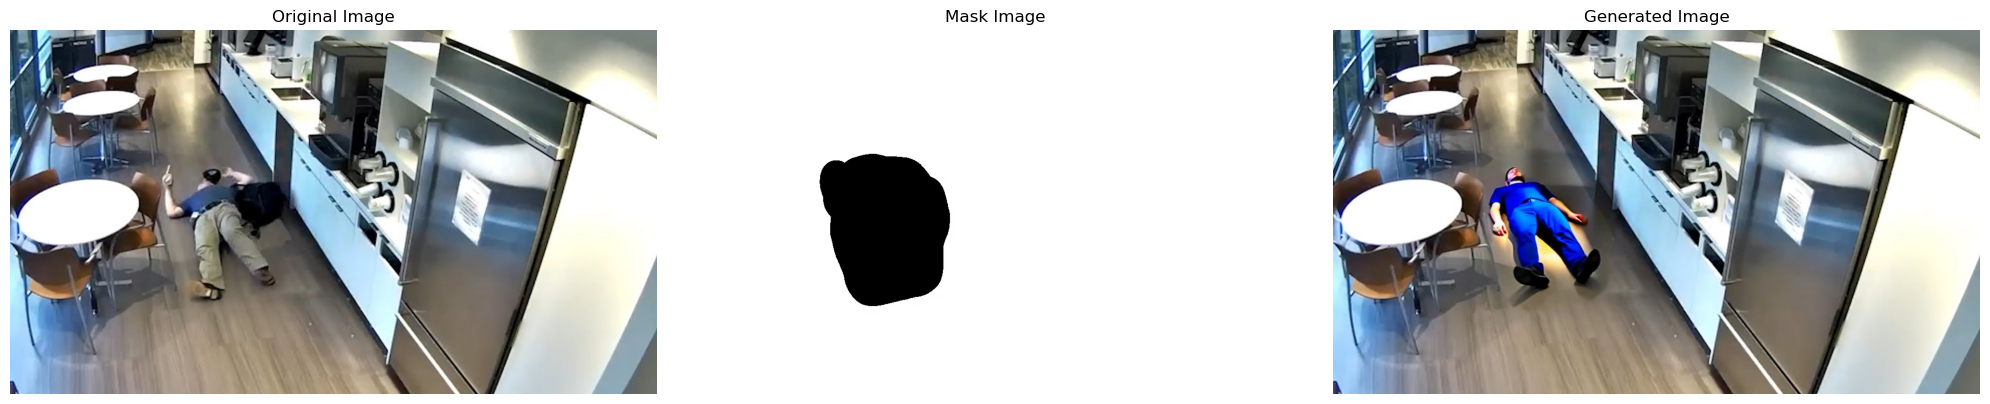

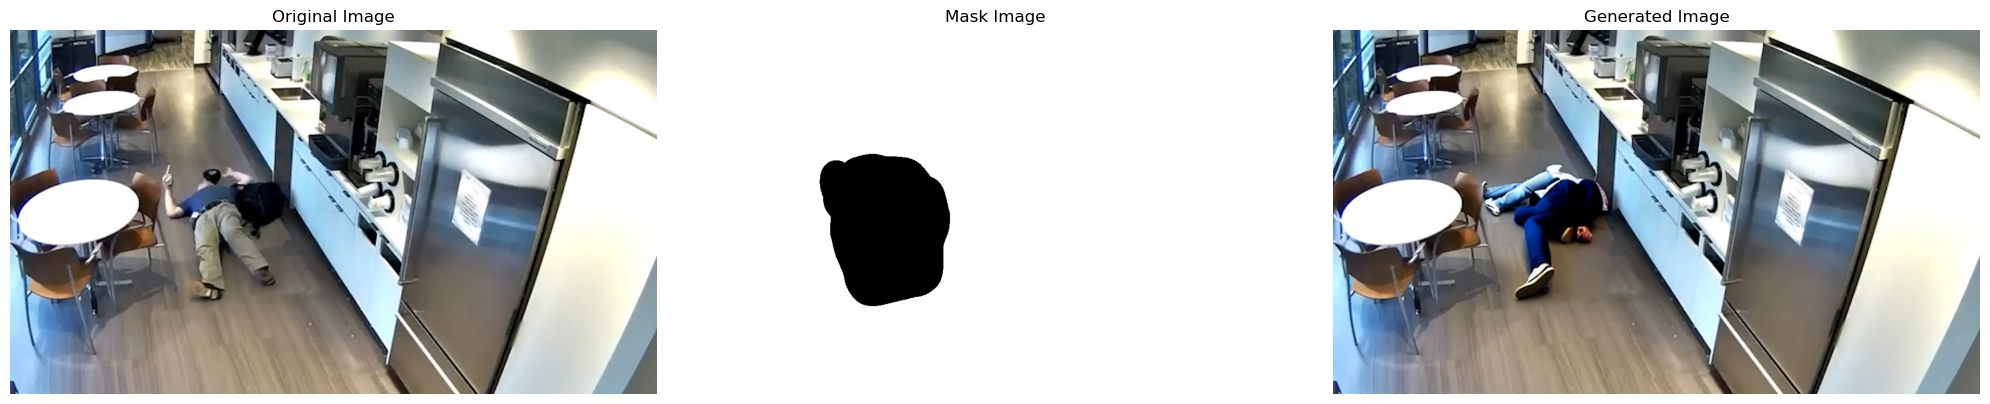

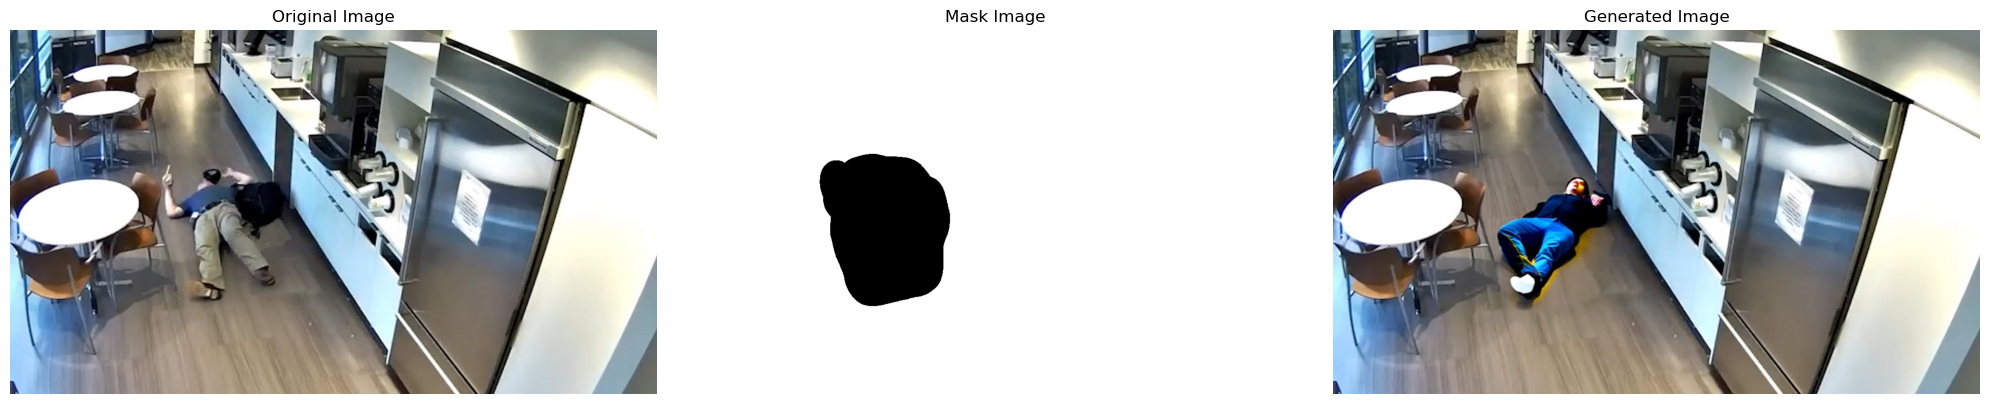

INFO:retry-bedrock-invocation:in retry(), _img_generation_show_and_store() returned 'completed'


'completed'

In [74]:
_img_generation_show_and_store(
    image_generation_model=image_generation_model,
    body=body,
    original_image_path=origin_img_path,
    mask_image_path=mask_img_path,
    output_path=output_path,
    seperator=seperator
)

#### Case 2: Add a subject
![nn](./imgs/img-variation/mask-2.png)

In [75]:
event_type = "event-fall"
seperator = "inpatinitng-type-2"

origin_img_path = f'./datasets/0-origin/{event_type}/1-event-fall.jpg'
origin_img_bytes, origin_img_base64 = _png_to_bytes(origin_img_path)

mask_img_path = f'./datasets/1-masking/{event_type}/inversed-masking/1-event-fall-mask-2-inverse.png'
mask_img_bytes, mask_img_base64 = _png_to_bytes(mask_img_path)
output_path = f'./datasets/2-variation/{event_type}'

In [76]:
body = json.dumps(
    {
        "taskType": "INPAINTING",
        "inPaintingParams": {
            "text": "Persons lying unconscious on the floor, full body view, realistic",
            "negativeText": "bad quality, low resolution, cartoon, blurry",
            "image": origin_img_base64,
            "maskImage": mask_img_base64
            #"maskPrompt": "washing machine"
        },
        "imageGenerationConfig": {
            "numberOfImages": 3,
            "height": 640,
            "width": 640,
            "cfgScale": 9.0,
            "quality": "premium", #"standard" | "premium",
            "seed": random.randint(0, 100000)
        }
    }
)

INFO:retry-bedrock-invocation:trying _img_generation_show_and_store() [1/5]


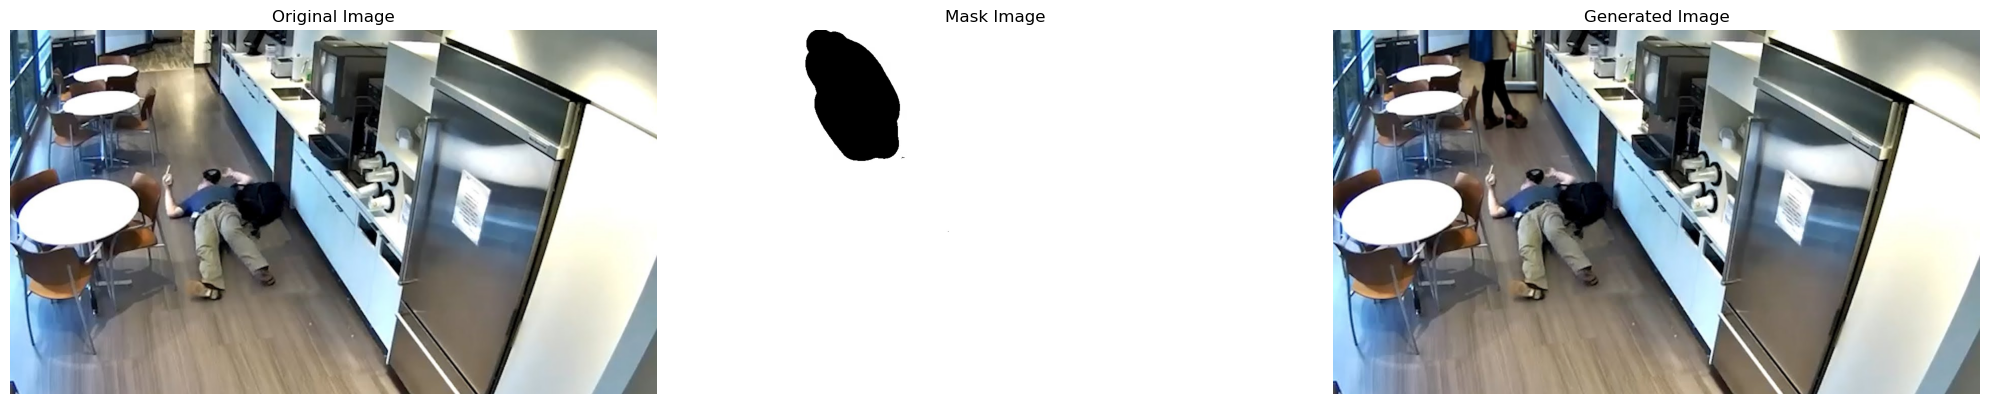

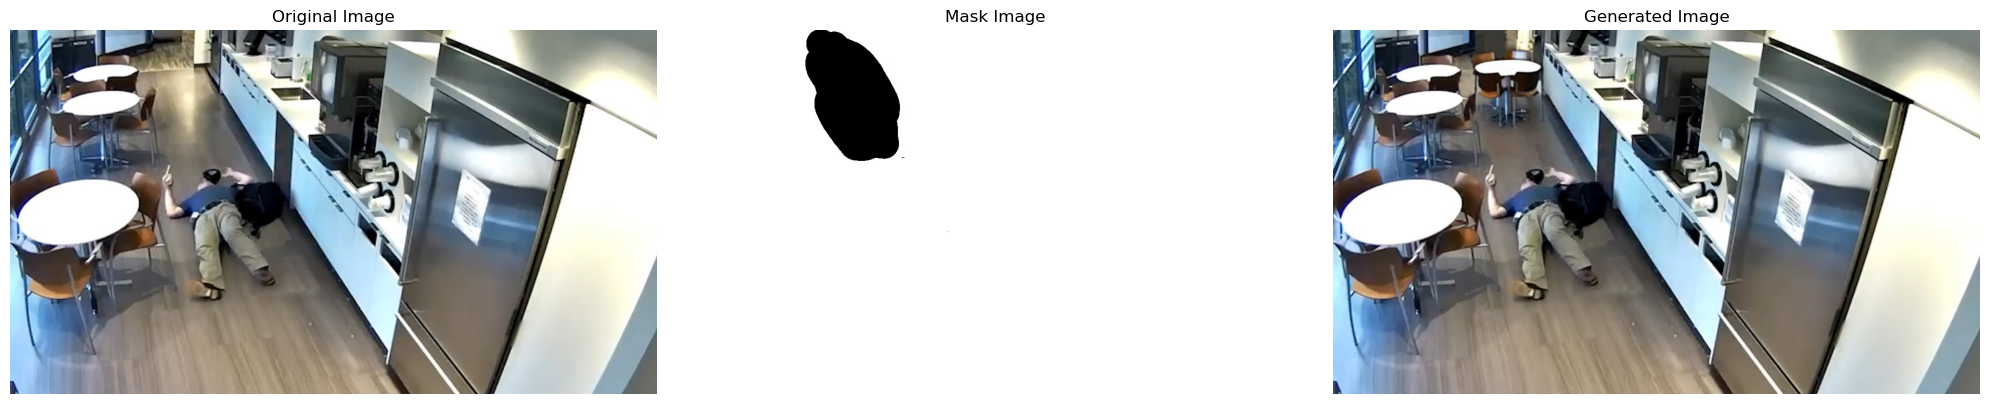

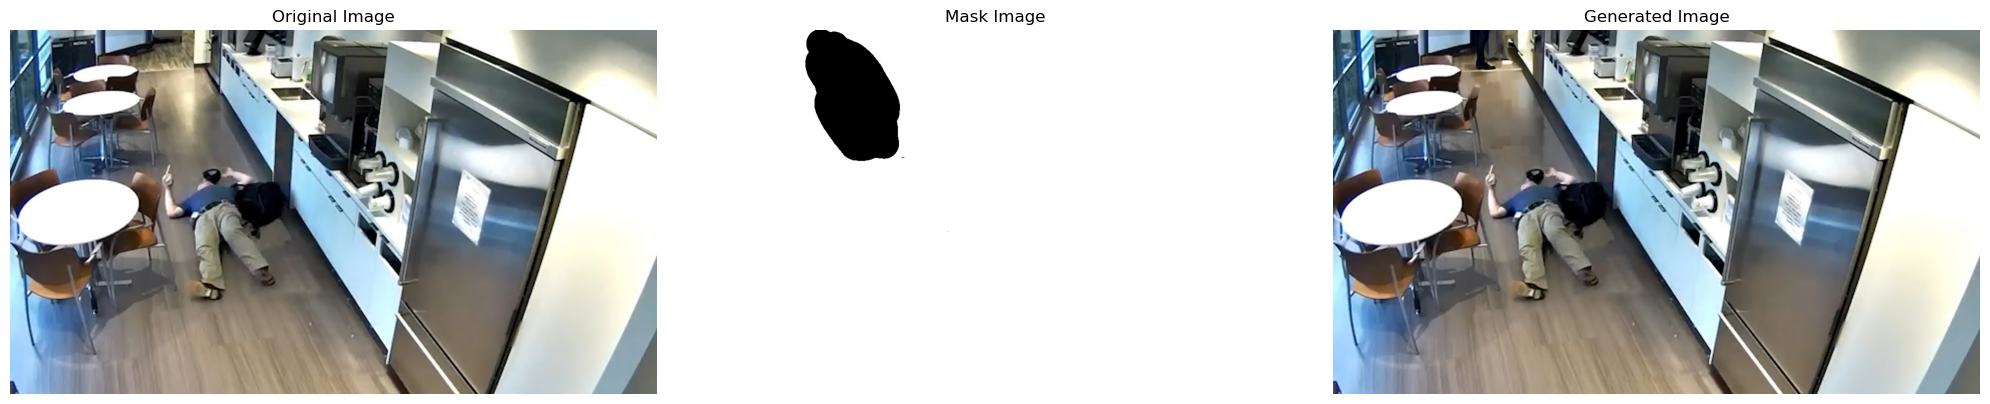

INFO:retry-bedrock-invocation:in retry(), _img_generation_show_and_store() returned 'completed'


'completed'

In [77]:
_img_generation_show_and_store(
    image_generation_model=image_generation_model,
    body=body,
    original_image_path=origin_img_path,
    mask_image_path=mask_img_path,
    output_path=output_path,
    seperator=seperator
)

### 4.2 `Image variation`

In [78]:
event_type = "event-fall"
seperator = "variation"

origin_img_path = f'./datasets/0-origin/{event_type}/1-event-fall.jpg'
origin_img_bytes, origin_img_base64 = _png_to_bytes(origin_img_path)
output_path = f'./datasets/2-variation/{event_type}'

In [79]:
body = json.dumps(
    {
        "taskType": "IMAGE_VARIATION",
        "imageVariationParams": {
            "text": "A person lying unconscious on the floor, top-down view from CCTV angle, surveillance camera perspective, high-angle shot, full body view",
            "negativeText": "bad quality, low resolution, cartoon, blurry",
            "images": [origin_img_base64],
            "similarityStrength": 1.0 # Range: 0.2 to 1.0 with lower values used to introduce more randomness.
        },
        "imageGenerationConfig": {
            "numberOfImages": 1, # max 5
            "quality": "premium",
            "height": 640,
            "width": 640,
            "cfgScale": 9,
            "seed": random.randint(0, 100000)
            
        }
    }
)

INFO:retry-bedrock-invocation:trying _img_generation_show_and_store() [1/5]


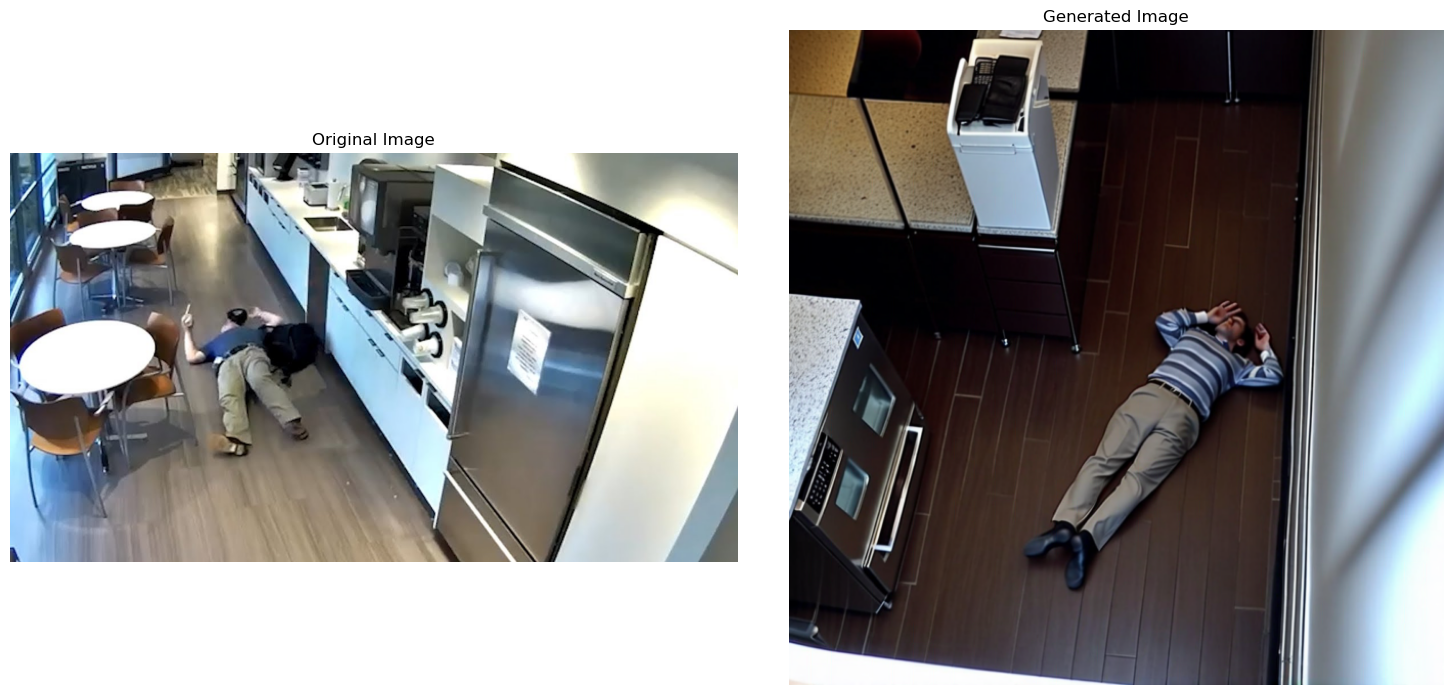

INFO:retry-bedrock-invocation:in retry(), _img_generation_show_and_store() returned 'completed'


'completed'

In [80]:
_img_generation_show_and_store(
    image_generation_model=image_generation_model,
    body=body,
    original_image_path=origin_img_path,
    output_path=output_path,
    seperator=seperator
)